# Non-Iterative Tuning Guide

## Hello World

Let's do a hybrid parameter tuning with grid search + random search, and run it distributedly

In [1]:
def objective(a, b) -> float:
    return a**2 + b**2

In [2]:
from tune import Space, Grid, Rand, RandInt, Choice

space = Space(a=Grid(-1,0,1), b=Rand(-10,10)).sample(100, seed=0)

In [3]:
from tune import suggest_for_noniterative_objective

result = suggest_for_noniterative_objective(objective, space, top_n=1)[0]
print(result.sort_metric, result.jsondict)

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT
0.1909396653178624 {'trial': {'trial_id': '43d7f6ed-749f-509e-a8a5-a4692aed8ed1', 'params': {'a': 0, 'b': 0.43696643500143395}, 'metadata': {}, 'keys': []}, 'metric': 0.1909396653178624, 'params': {'a': 0, 'b': 0.43696643500143395}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 0.1909396653178624, 'log_time': '2021-05-27 04:29:34.002261'}


Now run it distributedly, let's use dask as as the example

In [4]:
from fugue_dask import DaskExecutionEngine

result = suggest_for_noniterative_objective(
    objective, space, top_n=1,
    execution_engine = DaskExecutionEngine
)[0]

print(result.sort_metric, result.jsondict)

0.1909396653178624 {'trial': {'trial_id': '43d7f6ed-749f-509e-a8a5-a4692aed8ed1', 'params': {'a': 0, 'b': 0.43696643500143395}, 'metadata': {}, 'keys': []}, 'metric': 0.1909396653178624, 'params': {'a': 0, 'b': 0.43696643500143395}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 0.1909396653178624, 'log_time': '2021-05-27 04:29:35.978158'}


In order to use `tune` in a more elegant and easier way, let's firstly see how to configure the system.

## Configuration

Configuring the system is not necessary but it has great benefit for simpifying your following works.

`suggest_for_noniterative_objective` and `optimize_noniterative` have a lot of parameters due to the complexity of tuning operations. But `tune` let you do global configuration so you don't need to repeat the same configuration for every tuning task.

### Customize Optimizer Converter

In [5]:
from tune import TUNE_OBJECT_FACTORY
from tune import NonIterativeObjectiveLocalOptimizer
from tune_hyperopt import HyperoptLocalOptimizer
from tune_optuna import OptunaLocalOptimizer
import optuna

optuna.logging.disable_default_handler()

def to_optimizer(obj):
    if isinstance(obj, NonIterativeObjectiveLocalOptimizer):
        return obj
    if obj is None or "hyperopt"==obj:
        return HyperoptLocalOptimizer(max_iter=20, seed=0)
    if "optuna" == obj:
        return OptunaLocalOptimizer(max_iter=20)
    raise NotImplementedError

# make default level 2 optimizer HyperoptLocalOptimizer, so you will not need to set again
TUNE_OBJECT_FACTORY.set_noniterative_local_optimizer_converter(to_optimizer)

### Customize Monitor

Monitor is to collect and render information in real time, there are builtin monitors, you can also create your own.

In [6]:
from typing import Optional

from tune import TUNE_OBJECT_FACTORY
from tune import Monitor
from tune_notebook import (
    NotebookSimpleHist,
    NotebookSimpleRungs,
    NotebookSimpleTimeSeries,
    PrintBest,
)

def to_monitor(obj) -> Optional[Monitor]:
    if obj is None:
        return None
    if isinstance(obj, Monitor):
        return obj
    if isinstance(obj, str):
        if obj == "hist":
            return NotebookSimpleHist()
        if obj == "rungs":
            return NotebookSimpleRungs()
        if obj == "ts":
            return NotebookSimpleTimeSeries()
        if obj == "text":
            return PrintBest()
    raise NotImplementedError(obj)

TUNE_OBJECT_FACTORY.set_monitor_converter(to_monitor)

### Set Temp Path For Tuning

Temp path can be used to store serialized partitions or checkpoints. Most top level API usage requires a valid temporary path. We can use factory method to set a global value.

Notice if you want to tune distributedly, you should set the path to a distributed file system, for example s3.

In [7]:
TUNE_OBJECT_FACTORY.set_temp_path("/tmp")

## Tuning Examples

Sometimes, your objective function requires a input dataframe. There are two ways to use dataframes in general:

| | **Pros** | **Cons** |
| ---|---|---|
| **Take them as real dataframes, <br>for example pandas dataframes.** | Simple and intuitive | Either the datas ize can't scale or you have to <br>couple with a distributed solution such as Spark |
| **Take them from parameters, <br>for example paths as parameters.** | You have the full control how and when and whether <br>to load the data. More scalable. | More code to make it work |

In general, the second way is a better idea. But if your case can fit in the first scenario, then `tune` has a simple solution letting you take the pandas dataframes as input.

In [8]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

diabetes = load_diabetes(as_frame=True)["frame"]

def evaluate(train_df:pd.DataFrame, **kwargs) -> float:
    x, y = train_df.drop("target", axis=1), train_df["target"]
    model = RandomForestRegressor(**kwargs)
    # pay attention here, score is larger better so we return the negative value
    return -np.mean(cross_val_score(model, x, y, scoring="neg_mean_absolute_error", cv=4))

evaluate(diabetes)


46.646344389844394

With the given `diabetes` dataset and the objective function `evaluate` let's tune it in different ways

### Hybrid Tuning

In [9]:
# Grid search only
space = Space(n_estimators=Grid(100,200), random_state=0)

result = suggest_for_noniterative_objective(
    evaluate, space, top_n=1,
    df = diabetes, df_name = "train_df"
)[0]

print(result.sort_metric, result.jsondict)

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT
46.63103787878788 {'trial': {'trial_id': 'a9374e43-a585-57a5-85a8-5759e1cbfa36', 'params': {'n_estimators': 100, 'random_state': 0}, 'metadata': {}, 'keys': []}, 'metric': 46.63103787878788, 'params': {'n_estimators': 100, 'random_state': 0}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 46.63103787878788, 'log_time': '2021-05-27 04:29:42.276961'}


In [10]:
# grid + random
space = Space(n_estimators=Grid(100,200), max_depth=RandInt(2,10), random_state=0).sample(3, seed=0)

result = suggest_for_noniterative_objective(
    evaluate, space, top_n=1,
    df = diabetes, df_name = "train_df"
)[0]

print(result.sort_metric, result.jsondict)

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT
46.52677715635581 {'trial': {'trial_id': 'ff5050fb-81a0-5c0d-8583-40be953559cb', 'params': {'max_depth': 6, 'n_estimators': 200, 'random_state': 0}, 'metadata': {}, 'keys': []}, 'metric': 46.52677715635581, 'params': {'max_depth': 6, 'n_estimators': 200, 'random_state': 0}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 46.52677715635581, 'log_time': '2021-05-27 04:29:46.572459'}


In [11]:
# random + bayesian optimization (hyperopt is used by default)
space = Space(n_estimators=RandInt(50,200))* Space(max_depth=RandInt(2,10), random_state=0).sample(2, seed=0)

result = suggest_for_noniterative_objective(
    evaluate, space, top_n=1,
    df = diabetes, df_name = "train_df"
)[0]

print(result.sort_metric, result.jsondict)

result = suggest_for_noniterative_objective(
    evaluate, space, top_n=1,
    df = diabetes, df_name = "train_df",
    local_optimizer="optuna" # switch to optuna for bayesian optimization
)[0]

print(result.sort_metric, result.jsondict)

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT
NativeExecutionEngine doesn't respect num_partitions ROWCOUNT
46.419699856089416 {'trial': {'trial_id': '242197d6-ea63-50a8-b4fd-0fbc726ce933', 'params': {'n_estimators': 175, 'max_depth': 6, 'random_state': 0}, 'metadata': {}, 'keys': []}, 'metric': 46.419699856089416, 'params': {'n_estimators': 175, 'max_depth': 6, 'random_state': 0}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 46.419699856089416, 'log_time': '2021-05-27 04:29:55.408677'}
46.428149598166456 {'trial': {'trial_id': '242197d6-ea63-50a8-b4fd-0fbc726ce933', 'params': {'n_estimators': 177, 'max_depth': 6, 'random_state': 0}, 'metadata': {}, 'keys': []}, 'metric': 46.428149598166456, 'params': {'n_estimators': 177, 'max_depth': 6, 'random_state': 0}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 46.428149598166456, 'log_time': '2021-05-27 04:30:26.088952'}


### Partition And Train And Tune

This is a very important feature of `tune`. Sometimes, partitioning the data and train and tune small independent models separately can generate better result. This is not necessarily true, but at least we make it very simple for you to try. You only need to specify `partition_keys`. And with a distributed engine, all independent tasks are fully parallelized.

In [12]:
space = Space(n_estimators=Grid(50,200), max_depth=RandInt(2,10), random_state=0).sample(2, seed=0)

result = suggest_for_noniterative_objective(
    evaluate, space, top_n=1,
    df = diabetes, df_name = "train_df",
    partition_keys = ["sex"]  # for male and females, we train and tune separately
)

for r in result:
    print(r.trial.keys, r.sort_metric, r.jsondict)

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT
[0.0506801187398187] 42.48208345425722 {'trial': {'trial_id': 'c80e4002-6cfb-585f-b4b2-43e2f13acbee', 'params': {'max_depth': 8, 'n_estimators': 200, 'random_state': 0}, 'metadata': {}, 'keys': [0.0506801187398187]}, 'metric': 42.48208345425722, 'params': {'max_depth': 8, 'n_estimators': 200, 'random_state': 0}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 42.48208345425722, 'log_time': '2021-05-27 04:31:08.703580'}
[-0.044641636506989] 46.66399292343497 {'trial': {'trial_id': 'a5ae19f1-c8c8-5fdd-b60f-e95242442a86', 'params': {'max_depth': 8, 'n_estimators': 50, 'random_state': 0}, 'metadata': {}, 'keys': [-0.044641636506989]}, 'metric': 46.66399292343497, 'params': {'max_depth': 8, 'n_estimators': 50, 'random_state': 0}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 46.66399292343497, 'log_time': '2021-05-27 04:31:03.266404'}


### Distributed Tuning

`tune` is based on Fugue so it can run seamlessly using all Fugue supported execution engines and in the same way Fugue uses them.

In [13]:
# This space is a combination of grid and random search
# all level 1 searches, so it can be fully distributed
space = Space(n_estimators=Grid(50,200), max_depth=RandInt(2,10), random_state=0).sample(2, seed=0)

result = suggest_for_noniterative_objective(
    evaluate, space, top_n=1,
    df = diabetes, df_name = "train_df",
    partition_keys = ["sex"],
    execution_engine = DaskExecutionEngine  # this makes the tuning process distributed
)

for r in result:
    print(r.trial.keys, r.sort_metric, r.jsondict)

[0.0506801187398187] 42.75906136619413 {'trial': {'trial_id': '28dd642b-4943-5ebc-bece-40d0b709768f', 'params': {'max_depth': 6, 'n_estimators': 200, 'random_state': 0}, 'metadata': {}, 'keys': [0.0506801187398187]}, 'metric': 42.75906136619413, 'params': {'max_depth': 6, 'n_estimators': 200, 'random_state': 0}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 42.75906136619413, 'log_time': '2021-05-27 04:31:11.149380'}
[-0.044641636506989] 47.083441507614964 {'trial': {'trial_id': '653a8468-8d48-5c3a-8ca8-777c106e40a3', 'params': {'max_depth': 6, 'n_estimators': 200, 'random_state': 0}, 'metadata': {}, 'keys': [-0.044641636506989]}, 'metric': 47.083441507614964, 'params': {'max_depth': 6, 'n_estimators': 200, 'random_state': 0}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 47.083441507614964, 'log_time': '2021-05-27 04:31:13.884710'}


## Realtime Monitoring

Fugue framework can let workers communicate with driver in realtime (see [this](https://fugue-tutorials.readthedocs.io/en/latest/tutorials/rpc.html)). So `tune` leverages this feature for monitoring and iterative problems.



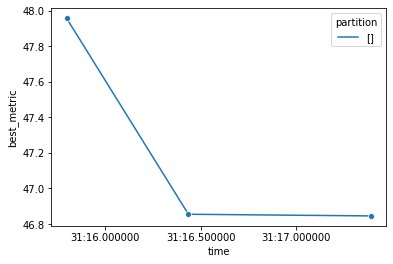

[] 46.84555314021837 {'trial': {'trial_id': '27497bd5-d39d-5955-bf3f-68c8f34af12e', 'params': {'max_depth': 3, 'n_estimators': 20, 'random_state': 0}, 'metadata': {}, 'keys': []}, 'metric': 46.84555314021837, 'params': {'max_depth': 3, 'n_estimators': 20, 'random_state': 0}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 46.84555314021837, 'log_time': '2021-05-27 04:31:17.391322'}
[] 46.84555314021837 {'trial': {'trial_id': '27497bd5-d39d-5955-bf3f-68c8f34af12e', 'params': {'max_depth': 3, 'n_estimators': 20, 'random_state': 0}, 'metadata': {}, 'keys': []}, 'metric': 46.84555314021837, 'params': {'max_depth': 3, 'n_estimators': 20, 'random_state': 0}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 46.84555314021837, 'log_time': '2021-05-27 04:31:21.483569'}


In [14]:
space = Space(n_estimators=RandInt(1,20), max_depth=RandInt(2,10), random_state=0).sample(100, seed=0)

result = suggest_for_noniterative_objective(
    evaluate, space, top_n=1,
    df = diabetes, df_name = "train_df",
    monitor="ts"
)

for r in result:
    print(r.trial.keys, r.sort_metric, r.jsondict)

To enable monitoring on a distributed engine, you must also enable [remote call back](https://fugue-tutorials.readthedocs.io/en/latest/tutorials/rpc.html). Without shortcut, you have to set multiple configs. Here is an [example](https://www.kaggle.com/goodwanghan/tune-tutorials-2-non-iterative-problems#Realtime-Monitoring) with the `fuggle` package who sets the shortcuts for callbacks on Kaggle, it's as simple as one config: `callback: True`

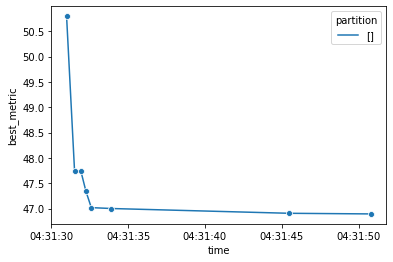

[] 46.89339381813802 {'trial': {'trial_id': '1325141f-2ee6-5b32-bff3-158b28a57f2a', 'params': {'max_depth': 5, 'n_estimators': 20, 'n_jobs': 1, 'random_state': 0}, 'metadata': {}, 'keys': []}, 'metric': 46.89339381813802, 'params': {'max_depth': 5, 'n_estimators': 20, 'n_jobs': 1, 'random_state': 0}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 46.89339381813802, 'log_time': '2021-05-27 04:31:50.795923'}
[] 46.89339381813802 {'trial': {'trial_id': '1325141f-2ee6-5b32-bff3-158b28a57f2a', 'params': {'max_depth': 5, 'n_estimators': 20, 'n_jobs': 1, 'random_state': 0}, 'metadata': {}, 'keys': []}, 'metric': 46.89339381813802, 'params': {'max_depth': 5, 'n_estimators': 20, 'n_jobs': 1, 'random_state': 0}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 46.89339381813802, 'log_time': '2021-05-27 04:31:50.795923'}


In [16]:
space = Space(n_estimators=RandInt(1,20), max_depth=RandInt(2,10), random_state=0, n_jobs=1).sample(200, seed=0)

callback_conf = {
    "fugue.rpc.server": "fugue.rpc.flask.FlaskRPCServer",
    "fugue.rpc.flask_server.host": "0.0.0.0",
    "fugue.rpc.flask_server.port": "1234",
    "fugue.rpc.flask_server.timeout": "2 sec",
}

result = suggest_for_noniterative_objective(
    evaluate, space, top_n=1,
    df = diabetes, df_name = "train_df",
    monitor="ts",
    execution_engine = DaskExecutionEngine,
    execution_engine_conf=callback_conf
)

for r in result:
    print(r.trial.keys, r.sort_metric, r.jsondict)

For the shortcuts of monitoring

1. `ts` to monitor the up-to-date best metric collected
2. `hist` to motitor the histogram of metrics collected

## Early Stopping

When you enable monitoring, you often see the curve flattens quickly, so it can save significant time if it can stop trying the remaining trials. To do early stopping, it is required to enable callbacks for distributed engine (for monitoring, if you don't monitor, you don't need to enable callback).

In `tune`, you can also combine stoppers with logical operators

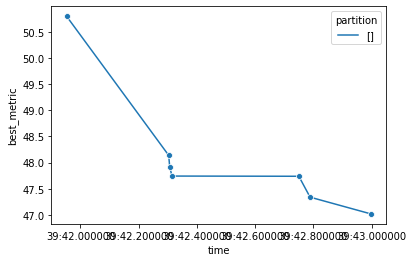

[] 47.01773216903467 {'trial': {'trial_id': 'f9d252db-57f5-558f-b4af-84c3d64f0b8c', 'params': {'max_depth': 4, 'n_estimators': 19, 'n_jobs': 1, 'random_state': 0}, 'metadata': {}, 'keys': []}, 'metric': 47.01773216903467, 'params': {'max_depth': 4, 'n_estimators': 19, 'n_jobs': 1, 'random_state': 0}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 47.01773216903467, 'log_time': '2021-05-27 04:39:42.954584'}
[] 47.01773216903467 {'trial': {'trial_id': 'f9d252db-57f5-558f-b4af-84c3d64f0b8c', 'params': {'max_depth': 4, 'n_estimators': 19, 'n_jobs': 1, 'random_state': 0}, 'metadata': {}, 'keys': []}, 'metric': 47.01773216903467, 'params': {'max_depth': 4, 'n_estimators': 19, 'n_jobs': 1, 'random_state': 0}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 47.01773216903467, 'log_time': '2021-05-27 04:39:42.954584'}


In [19]:
from tune import small_improvement, n_updates

space = Space(n_estimators=RandInt(1,20), max_depth=RandInt(2,10), random_state=0, n_jobs=1).sample(200, seed=0)

callback_conf = {
    "fugue.rpc.server": "fugue.rpc.flask.FlaskRPCServer",
    "fugue.rpc.flask_server.host": "0.0.0.0",
    "fugue.rpc.flask_server.port": "1234",
    "fugue.rpc.flask_server.timeout": "2 sec",
}

result = suggest_for_noniterative_objective(
    evaluate, space, top_n=1,
    df = diabetes, df_name = "train_df",
    monitor="ts",
    # stop if at least 5 updates on best 
    # AND the last update on best improved less than 0.1 (abs value)
    stopper= n_updates(5) & small_improvement(0.1,1),
    execution_engine = DaskExecutionEngine,
    execution_engine_conf=callback_conf
)

for r in result:
    print(r.trial.keys, r.sort_metric, r.jsondict)

The above example combined a warmup period `n_updates(5)` and improvement check `small_improvement(0.1,1)` so it does not stop too early or too late.

You can also customize a simple stopper

In [24]:
from typing import List
from tune.noniterative.stopper import SimpleNonIterativeStopper
from tune import TrialReport

def less_than(v: float) -> SimpleNonIterativeStopper:
    def func(current: TrialReport, updated: bool, reports: List[TrialReport]):
        return current.sort_metric <= v

    return SimpleNonIterativeStopper(func, log_best_only=True)


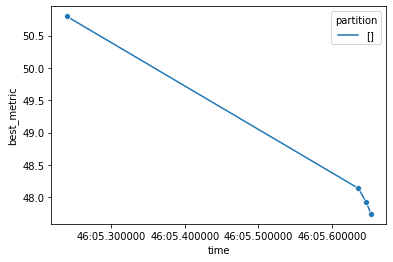

[] 47.74170052753941 {'trial': {'trial_id': '2cab62d7-4403-517a-8c46-da6022fe5901', 'params': {'max_depth': 2, 'n_estimators': 17, 'n_jobs': 1, 'random_state': 0}, 'metadata': {}, 'keys': []}, 'metric': 47.74170052753941, 'params': {'max_depth': 2, 'n_estimators': 17, 'n_jobs': 1, 'random_state': 0}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 47.74170052753941, 'log_time': '2021-05-27 04:46:05.273020'}
[] 47.74170052753941 {'trial': {'trial_id': '2cab62d7-4403-517a-8c46-da6022fe5901', 'params': {'max_depth': 2, 'n_estimators': 17, 'n_jobs': 1, 'random_state': 0}, 'metadata': {}, 'keys': []}, 'metric': 47.74170052753941, 'params': {'max_depth': 2, 'n_estimators': 17, 'n_jobs': 1, 'random_state': 0}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 47.74170052753941, 'log_time': '2021-05-27 04:46:05.273020'}


In [26]:
result = suggest_for_noniterative_objective(
    evaluate, space, top_n=1,
    df = diabetes, df_name = "train_df",
    monitor="ts",
    stopper= less_than(49),
    execution_engine = DaskExecutionEngine,
    execution_engine_conf=callback_conf
)

for r in result:
    print(r.trial.keys, r.sort_metric, r.jsondict)

The stopper will try to do graceful stop, so after the stop criteria, some running trials may still finish in with a distributed engine and report back, that is normal. If you want to stop faster, for example set: `stop_check_interval: "5sec"`. But if you have a lot of workers, the frequent check may be a burden on the driver side, it also depends on how heavy compute your custom stopper is using.

**Notice:** You must create new stoppers everytime you call `suggest_for_noniterative_objective` because `SimpleNonIterativeStopper` is stateful.